[nltk_data] Downloading package punkt to C:\Users\Admin\AppData\Local\
[nltk_data]     Programs\Python\Python312\lib\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Admin\AppData\Lo
[nltk_data]     cal\Programs\Python\Python312\lib\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Admin\AppDat
[nltk_data]     a\Local\Programs\Python\Python312\lib\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Processing video file...
MoviePy - Writing audio in extracted_audio.wav


MoviePy - Done.


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho


Transcription:
 THANK IT A CALLING MARTHUS FLARS TOWNASSIST YOU LOWA ROD COLUDER FLOWLIN A IF YOU HAVE WHAT A PICOR I' BEHAPP YOU' TAKE CARE OF YOUR ORDER MAY HAVE YOU NEEDPLEASE RANDOLD FOGER RAND OLL TONAS CAN YOU SPOUND OUT FOR ME RATER AINT   O O FATER A O RIR THANK IT FOR THATTY FOR MISTER RANDALL MAY HAVE YOUR HOMER OFFICE NUMBER HAIRI COAT FIRST THER GOOD FOLD ART TRI B I GOD GID PI ILO E THAT'S FOUR ZER NINE EIGHT SIX SIX FIVE SERO EIGHT EIGHT DO YOU HAVE CAT OF ER ERT ENAL ATCHES YONO TRANDL THOUGHT FATHER A KINE LOG TO RANDALL TOT THOGES AT YOU NO DAT COM TEY HAVE THER SHEEPING HATCHES BE FE GOD AKE RATHER RATERE BOLMO EDO GOD GOLDER GOTER FOT E USRE GLAD AS AVENUE BEAUWONT TEXAS ZICCOT SEVEN EVEN SEVEN ZERO SEATS THANK IV FOR THE INFORMATION WHAT PRODO TRA IS STED IN PECECY REU OU O ONE DOZEN OF RED ROSES DO YOU WANT LOCKS TENS TETU ALL RIGHT RANEL LET E PRODES THE ORDER WHAT WOMAN PLEASE  GRANDALIER ORGERING ONT DOZEN LOCKSTENT RED ROSES TE TOLOF OUT OF TE ORDERS F R DAUGH

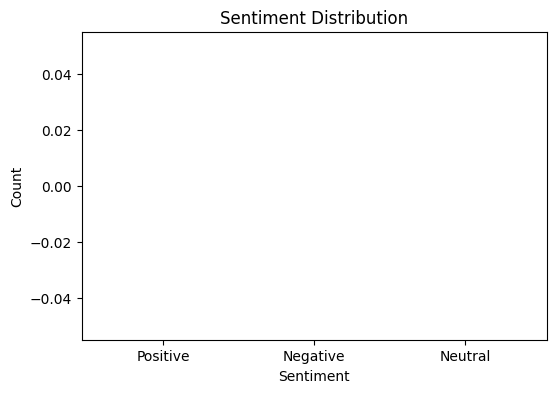

In [1]:
import soundfile as sf
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import spacy
import nltk
import numpy as np
from moviepy.editor import VideoFileClip  # For video file handling
from collections import Counter
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
import noisereduce as nr

# Correct downloads
nltk.download('punkt')  # For word/sentence tokenization
nltk.download('stopwords')  # Stopwords for filtering common words
nltk.download('vader_lexicon')  # For sentiment analysis

# Load spaCy model for Named Entity Recognition (NER)
nlp = spacy.load("en_core_web_sm")

# Initialize VADER sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Load NLTK stopwords list
stopwords = set(nltk.corpus.stopwords.words('english'))

# Function to transcribe audio
def transcribe_audio(audio_path):
    # Load the pre-trained ASR model and processor
    processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
    model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

    # Put the model in evaluation mode
    model.eval()

    # Read audio file
    speech, samplerate = sf.read(audio_path)

    # Ensure the audio is mono
    if len(speech.shape) > 1:
        speech = np.mean(speech, axis=1)

    # Apply noise reduction
    speech = nr.reduce_noise(y=speech, sr=samplerate, n_std_thresh_stationary=1.5)

    # Convert sample rate if needed
    if samplerate != 16000:
        from scipy.signal import resample
        num_samples = int(16000 * len(speech) / samplerate)
        speech = resample(speech, num_samples)

    # Segment audio if too long (e.g., more than 30 seconds)
    max_length = 16000 * 30  # 30 seconds
    if len(speech) > max_length:
        segments = [speech[i:i + max_length] for i in range(0, len(speech), max_length)]
        transcriptions = []
        for segment in segments:
            input_values = processor(segment, return_tensors="pt", padding="longest", sampling_rate=16000).input_values
            logits = model(input_values).logits
            predicted_ids = logits.argmax(dim=-1)
            transcription = processor.decode(predicted_ids[0])
            transcriptions.append(transcription)
        return ' '.join(transcriptions)

    # Preprocess and transcribe
    input_values = processor(speech, return_tensors="pt", padding="longest", sampling_rate=16000).input_values
    logits = model(input_values).logits
    predicted_ids = logits.argmax(dim=-1)
    transcription = processor.decode(predicted_ids[0])

    return transcription

# Function to extract audio from a video file
def extract_audio_from_video(video_path, output_audio_path="extracted_audio.wav"):
    video_clip = VideoFileClip(video_path)
    audio = video_clip.audio
    audio.write_audiofile(output_audio_path)
    return output_audio_path

# Function to preprocess text
def preprocess_text(text):
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.lower()

# Function to extract named entities (NER) as topics
def extract_named_entities(text):
    doc = nlp(text)
    entities = [(entity.text, entity.label_) for entity in doc.ents]
    return entities

# Function to analyze sentiment of the text
def analyze_sentiment(text):
    sentiment_scores = sentiment_analyzer.polarity_scores(text)
    compound_score = sentiment_scores['compound']

    # Classify sentiment as positive, negative, or neutral
    if compound_score >= 0.05:
        return "Positive", sentiment_scores
    elif compound_score <= -0.05:
        return "Negative", sentiment_scores
    else:
        return "Neutral", sentiment_scores

# Function to visualize sentiment distribution
def visualize_sentiment(sentiments):
    categories = ['Positive', 'Negative', 'Neutral']
    sentiment_counts = [sentiments.count(category) for category in categories]

    plt.figure(figsize=(6, 4))
    plt.bar(categories, sentiment_counts, color=['green', 'red', 'gray'])
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.title('Sentiment Distribution')
    plt.show()

# Function to extract and filter keywords by frequency
def extract_keywords(text, frequency_threshold=3):
    words = nltk.word_tokenize(text)
    words_filtered = [word for word in words if word not in stopwords and len(word) > 3]  # Filter stopwords and short words
    word_freq = Counter(words_filtered)

    # Only return words that appear more than 'frequency_threshold' times
    keywords = {word: count for word, count in word_freq.items() if count >= frequency_threshold}
    return keywords

# Function to perform topic modeling and extract topics
def perform_topic_modeling(texts, num_topics=3):
    # Tokenize and preprocess texts
    processed_texts = [preprocess_text(text).split() for text in texts]

    # Create a dictionary and corpus for LDA
    dictionary = Dictionary(processed_texts)
    corpus = [dictionary.doc2bow(text) for text in processed_texts]

    # Train the LDA model
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Extract topics
    topics = lda_model.print_topics(num_words=5)
    return topics

# Function to extract metadata: number of speakers, duration, number of words, etc.
def extract_metadata(transcription, audio_file, language="English"):
    # Use the transcription for word count
    word_count = len(transcription.split())

    # Extract duration of audio
    audio_info = sf.info(audio_file)
    duration = audio_info.duration

    # For simplicity, assume 1 speaker (can be enhanced using speaker diarization models)
    num_speakers = 1  # Placeholder, real implementation would involve speaker identification

    metadata = {
        "Language": language,
        "Duration (seconds)": duration,
        "Number of Words": word_count,
        "Number of Speakers": num_speakers
    }
    return metadata

# Function to display results and visualize the findings
def display_results(transcription, named_entities, sentiments, keywords, metadata, topics):
    # Display transcription
    print("\nTranscription:\n", transcription)

    # Display named entities (topics)
    print("\nNamed Entities (Main Topics):")
    for entity in named_entities:
        print(f"Entity: {entity[0]}, Type: {entity[1]}")

    # Display sentiment analysis
    print("\nSentiment Analysis:")
    for sentence, sentiment in sentiments:
        print(f"Sentence: {sentence}\nSentiment: {sentiment[0]}, Scores: {sentiment[1]}\n")

    # Display keyword frequency
    print("\nKeyword Frequency:")
    for word, freq in keywords.items():
        print(f"Word: {word}, Frequency: {freq}")

    # Display topics
    print("\nTopics:")
    for topic in topics:
        print(topic)

    # Display metadata
    print("\nConversation Metadata:")
    for key, value in metadata.items():
        print(f"{key}: {value}")

    # Visualize sentiment distribution
    sentiment_list = [s[0] for s in sentiments]
    visualize_sentiment(sentiment_list)

# Main function to process audio or video file, analyze sentiment, extract keywords, and display metadata
def main(file_path):
    # Check if the file is a video or audio
    if file_path.lower().endswith(('.mp4', '.mkv', '.avi', '.mov')):  # Video file formats
        print("Processing video file...")
        audio_file = extract_audio_from_video(file_path)
    else:
        print("Processing audio file...")
        audio_file = file_path

    # Step 1: Transcribe the audio
    transcription = transcribe_audio(audio_file)

    # Step 2: Preprocess the text
    cleaned_text = preprocess_text(transcription)

    # Step 3: Extract named entities (NER)
    named_entities = extract_named_entities(cleaned_text)

    # Step 4: Sentiment analysis for each sentence
    sentences = cleaned_text.split(".")  # Split text into sentences
    sentiments = []

    for sentence in sentences:
        if sentence.strip():  # Skip empty sentences
            sentiment = analyze_sentiment(sentence)
            sentiments.append((sentence, sentiment))

    # Step 5: Extract keyword frequencies
    keywords = extract_keywords(cleaned_text)

    # Step 6: Perform topic modeling
    texts = [cleaned_text]  # Wrap in a list for LDA
    topics = perform_topic_modeling(texts)

    # Step 7: Extract metadata
    metadata = extract_metadata(transcription, audio_file)

    # Step 8: Display results
    display_results(transcription, named_entities, sentiments, keywords, metadata, topics)

if __name__ == "__main__":
    file_path = 'C:/Users/Admin/Desktop/Project-2/SampleOrderTaking_CustomerSupport.mp4'  # Replace with your file path
    main(file_path)
